# Training an RNN on the Adding Problem

In this notebook we will train a simple Recurrent Neural Network on the adding problem. 
The adding problem is a typical task to benchmark RNNs, that consists in adding exactly two numbers (determined by a binary mask) between a sequence of random numbers in $[0, 1]$. 

This tasks can let us evaluate if the network has correctly learned time dependencies.

First, we load the necessary packages.


As a model choice, we will use a Long Short Term Memory (LSTM)

In [1]:
import sys

sys.path.append("..")
import torch
from torch.utils.data import Dataset, DataLoader
import jax
import numpy as np
import equinox as eqx  # pytree utilities
import optax  # optimizers
from einops import rearrange
from rnn_jax.cells import LongShortTermMemoryCell, LongShortTermMemory
from rnn_jax.layers import RNN
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt

In [2]:
key = jax.random.key(0)
in_key, out_key, key = jax.random.split(key, 3)
model = RNN(cell=LongShortTermMemoryCell(2, 64, key=in_key), odim=1, key=out_key)
#model = RNN(cell=LongShortTermMemory(2, 64, key=in_key), odim=1, key=out_key)

First, we make a simple utility function to make the adding problem dataset

In [3]:
BATCH_SIZE = 128


def make_adding_problem(n_samples=10_000, seq_len=100, key=key):
    import jax.random as jr
    import jax.numpy as jnp

    key1, key2, key3 = jr.split(key, 3)
    x = jr.uniform(key1, (n_samples, seq_len, 1))
    mask = jnp.zeros((n_samples, seq_len, 1))
    idx1 = jr.randint(key2, (n_samples,), 0, seq_len)
    idx2 = jr.randint(key3, (n_samples,), 0, seq_len - 1)
    idx2 = jnp.where(idx2 >= idx1, idx2 + 1, idx2)
    mask = mask.at[jnp.arange(n_samples), idx1, 0].set(1)
    mask = mask.at[jnp.arange(n_samples), idx2, 0].set(1)
    y = jnp.sum(x.squeeze(-1) * mask.squeeze(-1), axis=-1)
    return jnp.concatenate([x, mask], axis=-1), y


key, train_key, test_key = jax.random.split(key, 3)
X_train, y_train = make_adding_problem(key=train_key, seq_len=50)
X_test, y_test = make_adding_problem(n_samples=1000, key=test_key, seq_len=50)


class AddingProblemDataset(Dataset):
    def __init__(self, X, y):
        # Convert JAX → numpy → torch tensors
        self.X = torch.from_numpy(np.array(X))
        self.y = torch.from_numpy(np.array(y))

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # Inputs: (seq_len, 2), Targets: scalar
        return self.X[idx].float(), self.y[idx].float()


train_ds = AddingProblemDataset(X_train, y_train)
test_ds = AddingProblemDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

Now, we can write a simple training loop, Jax-style. 
Since our model is an `equinox.Module`, we can use the lifted `equinox.{vmap, filter}` instead of the Jax counterparts. 
Notice that for small models this *may* cause overheads. An alternative technique is using `equinox.filter(*, equinox.is_inexact_array)` and `equinox.partition`, to separate the static part (activation functions, hyperparameters) from the parameters,
and passing the static part, as you guessed, static arguments in the Jax transforms.

In [4]:
@eqx.filter_jit
def train_step(model: RNN, x, y, optimizer: optax.GradientTransformation, opt_state):
    # define a loss function
    @partial(
        eqx.filter_value_and_grad, has_aux=True
    )  # gets us the gradients w.r.t. the first argument (the model), in addition to the loss!
    def _loss_fn(model, x, y):
        y_pred, hidden_states = eqx.filter_vmap(model)(x)
        return jax.numpy.mean((y_pred - y[:, None]) ** 2), y_pred

    (loss, logits), grads = _loss_fn(model, x, y)
    updates, opt_state = optimizer.update(
        grads, opt_state
    )  # scales the gradients and updates the state (e.g. Adam's 1st and 2nd moments estimates)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, logits, loss


def train_model(
    model: RNN,
    dataloader: torch.utils.data.DataLoader,
    optimizer: optax.GradientTransformation,
    n_epochs,
):
    opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))
    epoch_losses = []
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}")
        loop = tqdm(dataloader)
        losses = []
        for x, y in loop:
            x = x.numpy()
            y = y.numpy()
            model, opt_state, logits, loss = train_step(
                model, x, y, optimizer, opt_state
            )
            loop.set_description(f"batch loss: {loss}")
            losses.append(loss)
        epoch_losses.append(np.mean(losses))
    return model, epoch_losses

It's training time! We will train for 50 epochs using Adam with a lr of 0.001. We also clip the gradient's norm to 1, to prevent exploding gradients.
This should take one or two minutes on a Macbook's M4 chip (CPU).

In [5]:
N_EPOCHS = 50
LR = 0.001
GRAD_CLIP_VALUE = 1.0
optimizer = optax.chain(
    optax.clip_by_global_norm(GRAD_CLIP_VALUE), optax.adam(learning_rate=LR)
)
model, losses = train_model(model, train_loader, optimizer, N_EPOCHS)

Epoch 1


batch loss: 0.20121052861213684: 100%|██████████| 79/79 [00:01<00:00, 50.67it/s]


Epoch 2


batch loss: 0.03869277238845825: 100%|██████████| 79/79 [00:00<00:00, 82.30it/s] 


Epoch 3


batch loss: 0.03225863724946976: 100%|██████████| 79/79 [00:00<00:00, 83.87it/s] 


Epoch 4


batch loss: 0.01053482573479414: 100%|██████████| 79/79 [00:00<00:00, 83.83it/s] 


Epoch 5


batch loss: 0.010953621007502079: 100%|██████████| 79/79 [00:00<00:00, 83.91it/s] 


Epoch 6


batch loss: 0.006975372321903706: 100%|██████████| 79/79 [00:00<00:00, 83.98it/s] 


Epoch 7


batch loss: 0.01742229238152504: 100%|██████████| 79/79 [00:00<00:00, 84.26it/s]  


Epoch 8


batch loss: 0.00316410674713552: 100%|██████████| 79/79 [00:00<00:00, 83.67it/s]  


Epoch 9


batch loss: 0.004157010931521654: 100%|██████████| 79/79 [00:00<00:00, 84.21it/s] 


Epoch 10


batch loss: 0.002023222390562296: 100%|██████████| 79/79 [00:00<00:00, 83.09it/s] 


Epoch 11


batch loss: 0.00156480073928833: 100%|██████████| 79/79 [00:00<00:00, 83.02it/s]  


Epoch 12


batch loss: 0.0015557885635644197: 100%|██████████| 79/79 [00:00<00:00, 83.86it/s]


Epoch 13


batch loss: 0.00042960973223671317: 100%|██████████| 79/79 [00:00<00:00, 82.98it/s]


Epoch 14


batch loss: 0.00043650425504893064: 100%|██████████| 79/79 [00:00<00:00, 83.97it/s]


Epoch 15


batch loss: 0.0006984482752159238: 100%|██████████| 79/79 [00:00<00:00, 83.68it/s] 


Epoch 16


batch loss: 0.0014752099523320794: 100%|██████████| 79/79 [00:00<00:00, 82.74it/s] 


Epoch 17


batch loss: 0.0006709352019242942: 100%|██████████| 79/79 [00:00<00:00, 83.54it/s]


Epoch 18


batch loss: 0.0005010585300624371: 100%|██████████| 79/79 [00:00<00:00, 83.62it/s] 


Epoch 19


batch loss: 0.0004263754526618868: 100%|██████████| 79/79 [00:00<00:00, 83.87it/s] 


Epoch 20


batch loss: 0.003909352235496044: 100%|██████████| 79/79 [00:00<00:00, 82.18it/s] 


Epoch 21


batch loss: 0.000502829032484442: 100%|██████████| 79/79 [00:00<00:00, 84.06it/s]  


Epoch 22


batch loss: 0.0007912653381936252: 100%|██████████| 79/79 [00:00<00:00, 82.36it/s] 


Epoch 23


batch loss: 0.0006705745472572744: 100%|██████████| 79/79 [00:00<00:00, 80.70it/s] 


Epoch 24


batch loss: 0.00016079067427199334: 100%|██████████| 79/79 [00:00<00:00, 81.82it/s]


Epoch 25


batch loss: 0.00031362089794129133: 100%|██████████| 79/79 [00:00<00:00, 83.06it/s]


Epoch 26


batch loss: 0.0008929288596846163: 100%|██████████| 79/79 [00:00<00:00, 83.73it/s] 


Epoch 27


batch loss: 0.00022027420345693827: 100%|██████████| 79/79 [00:00<00:00, 84.56it/s]


Epoch 28


batch loss: 0.0002145147736882791: 100%|██████████| 79/79 [00:00<00:00, 83.99it/s] 


Epoch 29


batch loss: 0.00022717387764714658: 100%|██████████| 79/79 [00:00<00:00, 83.56it/s]


Epoch 30


batch loss: 0.00033876573434099555: 100%|██████████| 79/79 [00:00<00:00, 83.29it/s]


Epoch 31


batch loss: 6.284033588599414e-05: 100%|██████████| 79/79 [00:00<00:00, 85.51it/s] 


Epoch 32


batch loss: 0.00019303627777844667: 100%|██████████| 79/79 [00:00<00:00, 83.77it/s]


Epoch 33


batch loss: 0.00019346280896570534: 100%|██████████| 79/79 [00:00<00:00, 82.77it/s]


Epoch 34


batch loss: 0.00031287610181607306: 100%|██████████| 79/79 [00:00<00:00, 82.25it/s]


Epoch 35


batch loss: 0.00027537840651348233: 100%|██████████| 79/79 [00:00<00:00, 83.25it/s]


Epoch 36


batch loss: 0.0009297849610447884: 100%|██████████| 79/79 [00:00<00:00, 83.35it/s] 


Epoch 37


batch loss: 0.00042027299059554935: 100%|██████████| 79/79 [00:00<00:00, 82.32it/s]


Epoch 38


batch loss: 0.0003636064939200878: 100%|██████████| 79/79 [00:00<00:00, 83.43it/s] 


Epoch 39


batch loss: 0.00029234011890366673: 100%|██████████| 79/79 [00:00<00:00, 82.79it/s]


Epoch 40


batch loss: 0.00037703150883316994: 100%|██████████| 79/79 [00:00<00:00, 83.06it/s]


Epoch 41


batch loss: 0.00019133258319925517: 100%|██████████| 79/79 [00:00<00:00, 83.25it/s]


Epoch 42


batch loss: 0.00011543287837412208: 100%|██████████| 79/79 [00:00<00:00, 82.87it/s]


Epoch 43


batch loss: 0.00015130345127545297: 100%|██████████| 79/79 [00:00<00:00, 82.70it/s]


Epoch 44


batch loss: 0.00037919546593911946: 100%|██████████| 79/79 [00:00<00:00, 82.57it/s]


Epoch 45


batch loss: 0.00014413738972507417: 100%|██████████| 79/79 [00:00<00:00, 81.45it/s]


Epoch 46


batch loss: 0.00020889667212031782: 100%|██████████| 79/79 [00:00<00:00, 83.12it/s]


Epoch 47


batch loss: 0.0003731809847522527: 100%|██████████| 79/79 [00:00<00:00, 83.00it/s]


Epoch 48


batch loss: 0.0005080472910776734: 100%|██████████| 79/79 [00:00<00:00, 82.64it/s] 


Epoch 49


batch loss: 0.00017030490562319756: 100%|██████████| 79/79 [00:00<00:00, 82.93it/s]


Epoch 50


batch loss: 0.00016783809405751526: 100%|██████████| 79/79 [00:00<00:00, 82.84it/s]


Let us look at the training curve, which should go down, judging from the logs

Total epochs: 50
Initial loss: 0.409373
Final loss: 0.000138


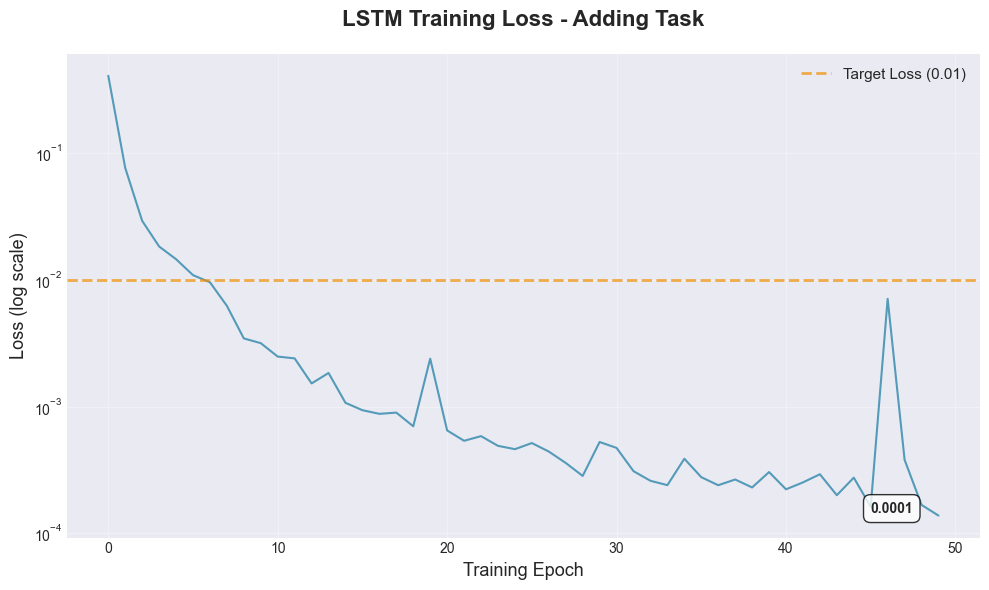

In [ ]:
print(f"Total epochs: {len(losses)}")
print(f"Initial loss: {losses[0]:.6f}")
print(f"Final loss: {losses[-1]:.6f}")

plt.figure(figsize=(10, 6))
plt.style.use("seaborn-v0_8-darkgrid")

# main plot
steps = np.arange(len(losses))
plt.semilogy(steps, np.array(losses), color="#2E86AB", linewidth=1.5, alpha=0.8)

# target line for a decent performance
plt.axhline(
    y=0.001,
    color="#F18F01",
    linestyle="--",
    linewidth=2,
    label="Target Loss (0.001)",
    alpha=0.7,
)

# annotations
plt.text(
    len(losses) * 0.95,
    losses[-1],
    f"{losses[-1]:.4f}",
    ha="right",
    va="bottom",
    fontsize=10,
    fontweight="bold",
    bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8),
)

# title and legend
plt.title("LSTM Training Loss - Adding Task", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Training Epoch", fontsize=13)
plt.ylabel("Loss (log scale)", fontsize=13)
plt.legend(loc="upper right", fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# save
plt.savefig("training_loss.png", dpi=300, bbox_inches="tight")
plt.show()

The curve looks good, reaching a value of around  $4\times 10^{-3}$.

Finally, we can evaluate the model on the test set, to assess the generalization capabilities

In [7]:
@eqx.filter_jit
def eval_step(model: RNN, x, y):
    # define a loss function
    y_pred, hidden_states = eqx.filter_vmap(model)(x)
    return jax.numpy.sum(optax.l2_loss(y_pred, y[:, None]))


def evaluate_model(model, dataloader):
    loss_sum = 0
    n_seen = 0
    for x, y in dataloader:
        x = x.numpy()
        y = y.numpy()
        loss_sum += eval_step(model, x, y)
        n_seen += len(x)
    print(f"Final MSE: {(loss_sum / n_seen):.6f}")


evaluate_model(model, test_loader)

Final MSE: 0.000080


Pretty good! Surely, with more training and better hyperparameters, we could reach a lower loss, but the network is correctly fitted. 